In [1]:

import geopandas
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point, Polygon
import numpy as np
import googlemaps
from datetime import datetime
import json
plt.rcParams["figure.figsize"] = [8,6]


# The file here looks at all California Dept of Fires (CDF) data from 2020 onwards. Polygons are thus mostly limited to California.
fires = GeoDataFrame.from_file('/Users/asattiraju/Desktop/wildfire-detection/preprocessing/Interagency_Fire_Perimeter_History_-_All_Years (2)/InteragencyFirePerimeterHistory.shp')



In [ ]:
fires.shape

<AxesSubplot:>

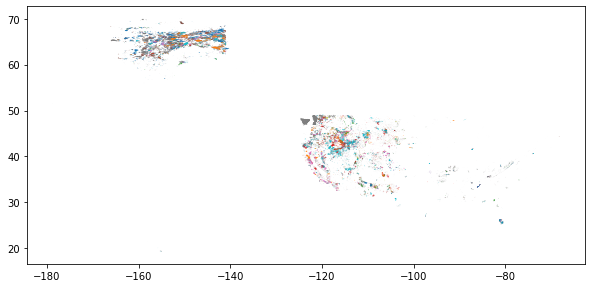

In [3]:
# FID looks like just the row numbers given after the filtering done on the dept end - nothing useful 
# Object ID may take into account the fact that we have filtered the data (some get skipped here and there).
fires = fires.set_index('FID')
fires = fires.sort_index()

# Plot and color by map_method. In other words, provide different colors for different classifications (e.g. blue for GPS Ground, red for Infrared)
# Not really needed, but interesting to see, and we can use this later in our analysis if needed.
fires.plot(column = 'MAP_METHOD', figsize=(10,10), aspect=1)


In [97]:
fires.geometry

FID
1         POLYGON ((-121.34840 38.88999, -121.34835 38.8...
2         POLYGON ((-121.35275 38.82038, -121.35267 38.8...
3         POLYGON ((-121.33333 38.84558, -121.33311 38.8...
4         POLYGON ((-121.27317 38.96308, -121.27304 38.9...
5         POLYGON ((-121.30065 39.48714, -121.30041 39.4...
                                ...                        
107500    POLYGON ((-123.16243 40.00681, -123.16231 40.0...
107637    POLYGON ((-115.48708 41.97660, -115.48704 41.9...
107679    POLYGON ((-123.53119 42.11428, -123.53111 42.1...
107845    POLYGON ((-115.67550 41.95754, -115.67550 41.9...
107857    POLYGON ((-122.38670 42.00859, -122.38672 42.0...
Name: geometry, Length: 14627, dtype: geometry

In [4]:
%matplotlib agg
%matplotlib agg

# Bottom left corner
boundy1, boundx1 = 32.5239920572277, -124.38498819727948
# Top right corner (near top right of nevada to capture all of CA)
boundy2, boundx2 = 42.01477274871176, -114.13276715586254


plt.gca().set_xlim([boundx1, boundx2])
plt.gca().set_ylim([boundy1, boundy2])

# make a grid of latitude-longitude values
xmin, xmax, ymin, ymax = boundx1, boundx2, boundy1, boundy2

# Calculation to ensure length and width are uniform (squares appx., not rectangles)
# 400 squares width for the length of california (based on the above boundaries)
# Note here that xx, yy are for ALL OF california. Use xc, yc for the specific region.
granularity = 400
xx, yy = np.meshgrid(np.linspace(xmin,xmax,granularity), np.linspace(ymin,ymax, int(granularity/abs(xmax - xmin) * abs(ymax - ymin))))
print(xx.shape) # Again, xx, yy are rectangular grids on the entirety of CA (+ Nevada, ocean)

(370, 400)


In [5]:
# Rectangular Area to initially explore for project.
# Top Left
yurok_reservation_long = -123.891719
yurok_reservation_lat = 41.372322

# Bottom Right (travis air force base)
travis_long = -121.939857
travis_lat = 38.272118

# xx, yy above are all valid points we can explore in the future (the entire grid of points in California (+ ocean, to be filtered))
# Filter by locations that are contained within the region rectangle.
region_indcs = np.where(np.logical_and(np.logical_and(xx >= yurok_reservation_long, xx <= travis_long), np.logical_and(yy >= travis_lat, yy <= yurok_reservation_lat)))

xc = xx[region_indcs]
yc = yy[region_indcs]
print('# of Coordinates to explore in region: ' + str(len(xc)))

# of Coordinates to explore in region: 9196


In [10]:
fires = fires[fires.geometry.notnull()]

<AxesSubplot:>

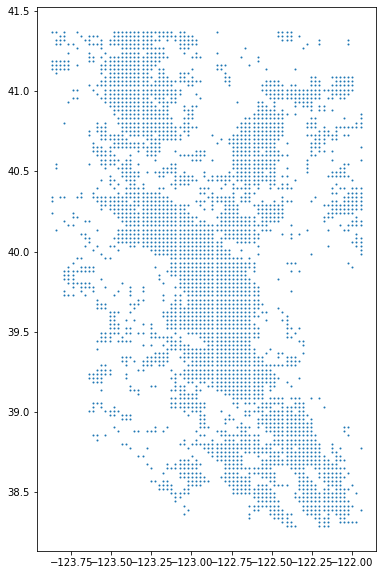

In [12]:
%matplotlib inline

# Now convert these points to geo-data - may take a few minutes to do at most.

# Credit -https://stackoverflow.com/questions/55199436/generate-grid-of-latitude-longitude-coordinates-that-fall-within-polygon
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
in_map =  np.array([pts.within(geom) for geom in fires.geometry]).sum(axis=0)
pts = GeoSeries([val for pos,val in enumerate(pts) if in_map[pos]])

pts.plot(markersize=1, figsize=(10,10), aspect=1)

In [20]:
years = np.array(fires.FIRE_YEAR)
years = years[np.where(in_map != 0)[0]]

In [21]:
len(years)

3474

In [22]:
# Place the list of all relevant coordinates into a json file. For now, each of them point to blank {}
# In the future, they point to the features:data (e.g. {feature1: datum1, feature2:datum2, ...} as value per pair of coords)
region_coords = {}

years = np.array(fires.FIRE_YEAR)
years = years[np.where(in_map != 0)[0]]


result = []
for n, point in enumerate(pts):
    coords = [','.join(__ for __ in _.strip().split(' ')[::-1]) for _ in str(point).split('(')[1].split(')')[0].split(',')]
    coords = coords[0].split(',')
    result.append([float(coords[0]), float(coords[1])])

for i in range(len(xc)):
    curr = [float(yc[i]), float(xc[i])]
    
    if curr in result:
        idx = result.index(curr)
        year = years[idx]
        
        occ = 1
    else:
        occ = 0
        year = -1 # change this
        
    
    occ = str(occ)
        
        
    region_coords[str(xc[i]) + ',' + str(yc[i])] = {"wildfire": occ, "year": year}

with open('wildfire_occurrencesv2.json', 'w') as f:
    json.dump(region_coords, f)